In [1]:
# Python Path non-sense
%load_ext autoreload
%autoreload 2

import sys
import os

# remove any paths that contains 'bayes_gsl' in the sys.path
sys.path = [x for x in sys.path if 'bayes_gsl' not in x]
new_path = '/Users/maxw/projects/gsl-bnn/'
if new_path not in sys.path:
    sys.path.append(new_path)

In [2]:
import numpy as np
import pickle
import multiprocessing
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.linear_model import LinearRegression

### THIS MUST OCCUR BEFORE JAX IS IMPORTED ###
# for parallelization for multiple chains. Must be done before jax import:
# Blackjax tutorial: https://blackjax-devs.github.io/blackjax/examples/howto_sample_multiple_chains.html
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
import jax
import jax.numpy as jnp
from jax import random

from numpyro.infer import MCMC, NUTS, Predictive

from src.utils import adj2vec, vec2adj, degrees_from_upper_tri, edge_density, edge_density_vmap
from experiments.predictive_checking.config import dpg_hyperparameters, experiment_settings
from src.config import original_prior, altered_prior
from src.config import num_samples_to_generate, w_init_scale, lam_init_scale
from src.models import dpg_bnn
from src import FIGURES_PATH

In [3]:
def load_data():
    data_dict = pickle.load(open(experiment_settings['data_path'], "rb"))

    # data is pairs of adjacency matrices and euclidean distance matrices
    adjacencies = data_dict['adjacencies'].astype(np.float32)
    dataset_key = 'expected' if experiment_settings['num_signals'] == float('inf') else str(experiment_settings['num_signals'])
    euclidean_distance_matrices = data_dict[dataset_key]

    # convert to vectors
    adjacencies = adj2vec(adjacencies)
    euclidean_distance_matrices = adj2vec(euclidean_distance_matrices)
    num_edges = adjacencies.shape[-1]

    # concatenate for easier processing
    data = np.concatenate([euclidean_distance_matrices, adjacencies], axis=1)

    # predetermine train/val/test split
    num_train, num_val, num_test = num_samples_to_generate['train'], num_samples_to_generate['val'], num_samples_to_generate['test']
    train, val, test = data[:num_train], data[num_train:num_train + num_val], data[num_train + num_val:]
    data =  {"train": (train[:, :num_edges], train[:, num_edges:]), 
            "val": (val[:, :num_edges], val[:, num_edges:]),
            "test": (test[:, :num_edges], test[:, num_edges:])}

    # unpack data
    x_train, y_train = jnp.array(data['train'][0]), jnp.array(data['train'][1])
    x_train, y_train = x_train[:experiment_settings['num_train_samples']], y_train[:experiment_settings['num_train_samples']]

    x_val, y_val = jnp.array(data['val'][0]), jnp.array(data['val'][1])
    x_val, y_val = x_val[:experiment_settings['num_val_samples']], y_val[:experiment_settings['num_val_samples']]
    
    x_test, y_test = jnp.array(data['test'][0]), jnp.array(data['test'][1])
    x_test, y_test = x_test[:experiment_settings['num_test_samples']], y_test[:experiment_settings['num_test_samples']]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data()
print(x_val.shape, y_val.shape)

(5, 190) (5, 190)


## Prior Predictive Check

In [4]:
num_edges = x_val.shape[-1]
n = int(0.5*(np.sqrt(8 * num_edges + 1) + 1))
S = jnp.array(degrees_from_upper_tri(n))

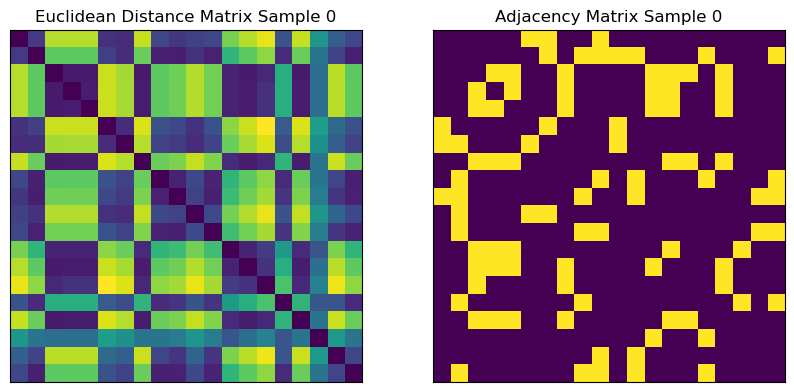

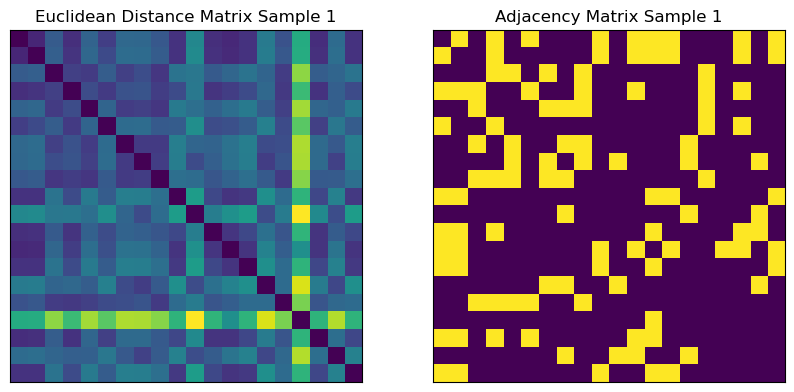

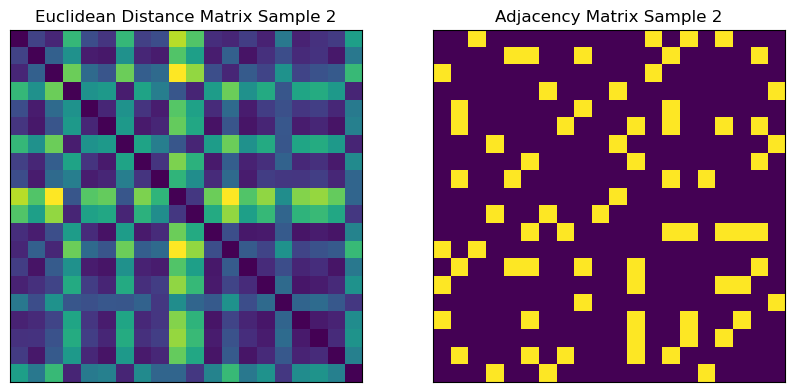

In [5]:
# Inspect a few input/label pairs
# use matplotlib to plot the euclidean distance matrices in x_val
x_val_adj = vec2adj(x_val, n=n)
y_val_adj = vec2adj(y_val, n=n)

import matplotlib.pyplot as plt
for idx in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(x_val_adj[idx])
    ax[1].imshow(y_val_adj[idx])
    for ax_ in ax:
        ax_.set_xticks([])
        ax_.set_yticks([])
    # add title
    ax[0].set_title('Euclidean Distance Matrix Sample {}'.format(idx))
    ax[1].set_title('Adjacency Matrix Sample {}'.format(idx))
    plt.show()

In [6]:
# Set up the Prior Predictive Check for the original prior and the altered prior. Note in the modeling process 
#   we started with the original prior, saw that it did not match prior beliefs about sparsity characterictics, 
#   and then adjust the prior via independently interpretable parameter \theta
num_edges = x_val.shape[-1]
n = int(0.5*(np.sqrt(8 * num_edges + 1) + 1))
S = jnp.array(degrees_from_upper_tri(n))

original_prior_model_args = \
    {'x': x_val, 'y': None,
     'depth': dpg_hyperparameters['depth'],
     'w_init': w_init_scale * jnp.ones((len(x_val), num_edges)), 
     'lam_init': lam_init_scale * jnp.ones((len(x_val), n)),
     'S': S,
     'prior_settings': original_prior}

altered_prior_model_args = original_prior_model_args.copy()
altered_prior_model_args['prior_settings'] = altered_prior


In [7]:
# Perform the Prior Predictive Check here.
rng_key = random.PRNGKey(experiment_settings['random_seed'])
rng_key, rng_key_ = random.split(rng_key)

prior_predictive_original = Predictive(dpg_bnn.model, num_samples=experiment_settings['num_prior_samples'])
prior_predictions_original = prior_predictive_original(rng_key=rng_key_, **original_prior_model_args)['obs'] # shape: num_prior_samples x num_val_samples x num_edges

prior_predictive_altered = Predictive(dpg_bnn.model, num_samples=experiment_settings['num_prior_samples'])
prior_predictions_altered = prior_predictive_altered(rng_key=rng_key_, **altered_prior_model_args)['obs']

In [8]:
prior_predictions_original.shape

(10000, 5, 190)

Inspecting prior predictive samples for validation sample 1 from the original prior


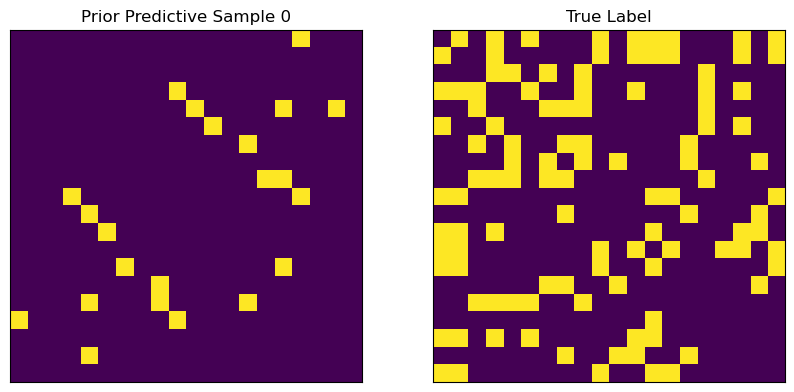

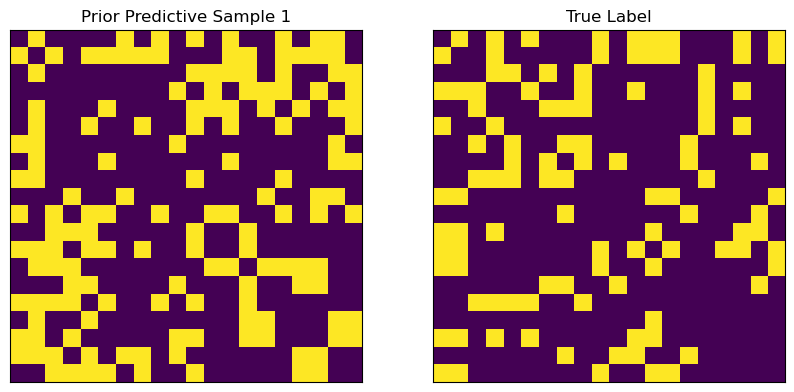

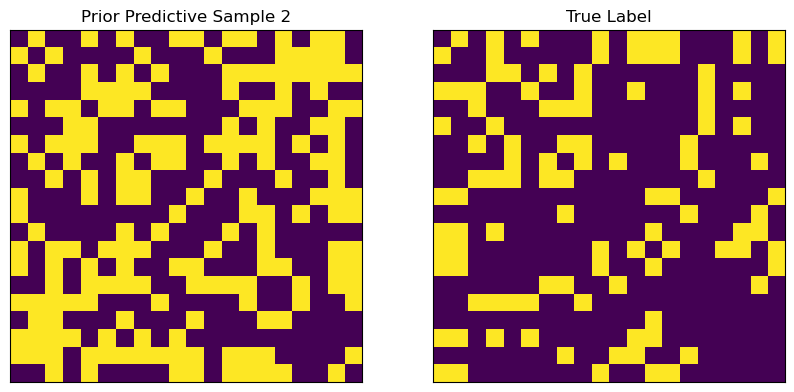

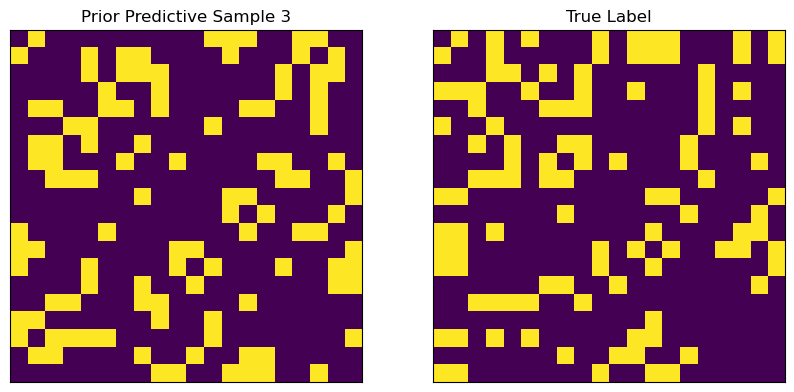

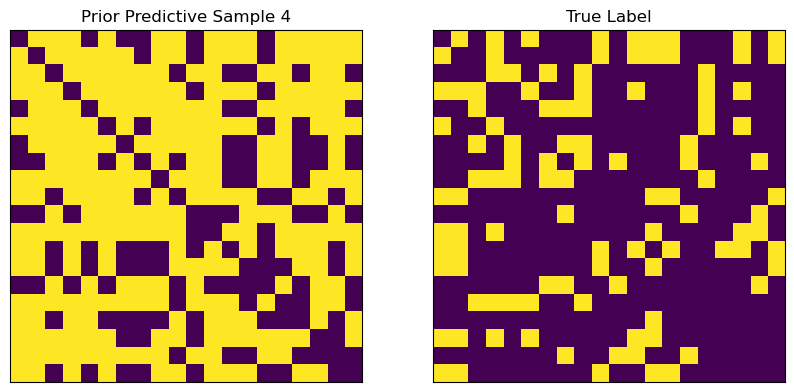

In [9]:
# Inspect some prior predictive samples from the original prior
val_sample_idx = 1
print(f"Inspecting prior predictive samples for validation sample {val_sample_idx} from the original prior")
for idx in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    first_samples_pps = prior_predictions_original[idx, val_sample_idx]
    first_sample_pps_adj = vec2adj(first_samples_pps.reshape(1, -1), n=n)[0]
    ax[0].imshow(first_sample_pps_adj)
    ax[1].imshow(y_val_adj[val_sample_idx])
    ax[0].set_title(f'Prior Predictive Sample {idx}')
    ax[1].set_title('True Label')
    # remove all xticks and yticks
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

In [10]:
"""
    Edge Density
"""
edge_densities_original = jnp.mean(edge_density_vmap(prior_predictions_original), axis=1)
edge_densities_altered = jnp.mean(edge_density_vmap(prior_predictions_altered), axis=1)
#edge_densities_posterior = jnp.mean(edge_density_vmap(posterior_predictions), axis=1)

edge_density_observed_data = np.mean(edge_density(y_val))

def freq_interval(metric, low, high):
    return np.mean((metric > low) & (metric < high))
print(f" ** Note how the altered prior shifts some probability mass over higher density outputs. **")
intervals = np.linspace(0, 1, 5)
for low, high in zip(intervals[:-1], intervals[1:]):
    print(f'Fraction of edge densities in [{low:.2f}, {high:.2f}] ', end='')
    print(f'o.g.: {freq_interval(edge_densities_original, low, high)*100:.1f} | ', end='')
    print(f'alter: {freq_interval(edge_densities_altered, low, high)*100:.1f} | ', end='')
    print(f'abs change: {np.abs(freq_interval(edge_densities_original, low, high) - freq_interval(edge_densities_altered, low, high))*100:.1f}')
    #print(f'posterior: {freq_interval(edge_densities_posterior, low, high):.3f}')


 ** Note how the altered prior shifts some probability mass over higher density outputs. **
Fraction of edge densities in [0.00, 0.25] o.g.: 28.5 | alter: 20.8 | abs change: 7.7
Fraction of edge densities in [0.25, 0.50] o.g.: 42.2 | alter: 35.0 | abs change: 7.1
Fraction of edge densities in [0.50, 0.75] o.g.: 22.5 | alter: 29.3 | abs change: 6.7
Fraction of edge densities in [0.75, 1.00] o.g.: 4.1 | alter: 11.1 | abs change: 7.0


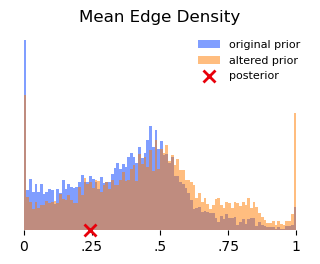

In [11]:
def predictive_check_combined_hist(edge_densities_original, edge_densities_altered, edge_density_observed_data, edge_density_posterior=None):
    fig, axes = plt.subplots(1, 1, figsize=(3, 2))
    alpha = 0.5
    # edge densities
    colors = sns.color_palette('bright', 4)
    axes.hist(np.array(edge_densities_original).flatten(), color=colors[0], alpha=alpha, density=True, bins=100, label='original prior')
    axes.hist(np.array(edge_densities_altered).flatten(), color=colors[1], alpha=alpha, density=True, bins=100, label='altered prior')
    
    # Twin the x-axis for posterior if it exists
    if edge_density_posterior is not None:
        axes2 = axes.twinx()
        axes2.hist(np.array(edge_density_posterior).flatten(), color=colors[2], alpha=alpha, density=True, bins=100, label='posterior')
        # remove yticks and labels for the twin x-axis
        axes2.set_yticks([])

    # place an 'x' at x=.25 on the x axis
    axes.plot(edge_density_observed_data, 0, 'x', color=colors[3], label='labels', markersize=8, markeredgewidth=2, clip_on=False)

    # remove yticks and labels for the main axis
    axes.set_yticks([])
    axes.set_ylabel('')
    
    # remove frame on all sides for both axes
    for ax in [axes, axes2] if edge_density_posterior is not None else [axes]:
        for side in ['top', 'right', 'bottom', 'left']:
            ax.spines[side].set_visible(False)

    # set xticks manually to be 0, 0.25, 0.5, 0.75, 1 without leading 0
    axes.set_xticks([0, 0.25, 0.5, 0.75, 1])
    axes.set_xticklabels(['0', '.25', '.5', '.75', '1'])
    #axes.set_xlabel('Average Edge Density')
    # set title
    axes.set_title('Mean Edge Density')

    # Collect handles and labels from both axes
    handles, labels = axes.get_legend_handles_labels()
    if edge_density_posterior is not None:
        handles2, labels2 = axes2.get_legend_handles_labels()
        handles.extend(handles2)
        labels.extend(labels2)

    # Order legend manually
    ordered_labels = ['original prior', 'altered prior', 'posterior', 'labels']
    ordered_handles = [h for l, h in sorted(zip(labels, handles), key=lambda pair: ordered_labels.index(pair[0]))]

    # Set the legend with the ordered handles and labels
    axes.legend(ordered_handles, ordered_labels, loc='upper right', frameon=False, fontsize=8)
    

    # Adjust subplot parameters
    plt.subplots_adjust(wspace=0, hspace=0, bottom=0.0, top=1, left=0.0, right=1.0)
    return

predictive_check_combined_hist(edge_densities_original, edge_densities_altered, edge_density_observed_data)

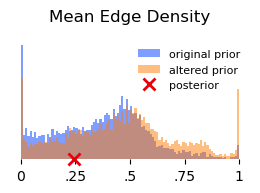

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def predictive_check_combined_hist(edge_densities_original, edge_densities_altered, edge_density_observed_data, edge_density_posterior=None):
    fig, axes = plt.subplots(1, 1, figsize=(3, 2))
    alpha = 0.5
    # edge densities
    colors = sns.color_palette('bright', 4)
    axes.hist(np.array(edge_densities_original).flatten(), color=colors[0], alpha=alpha, density=True, bins=100, label='original prior')
    axes.hist(np.array(edge_densities_altered).flatten(), color=colors[1], alpha=alpha, density=True, bins=100, label='altered prior')
    
    # Twin the x-axis for posterior if it exists
    if edge_density_posterior is not None:
        axes2 = axes.twinx()
        axes2.hist(np.array(edge_density_posterior).flatten(), color=colors[2], alpha=alpha, density=True, bins=100, label='posterior')
        # remove yticks and labels for the twin x-axis
        axes2.set_yticks([])

    # place an 'x' at x=.25 on the x axis
    axes.plot(edge_density_observed_data, 0, 'x', color=colors[3], label='labels', markersize=8, markeredgewidth=2, clip_on=False)

    # remove yticks and labels for the main axis
    axes.set_yticks([])
    axes.set_ylabel('')
    
    # remove frame on all sides for both axes
    for ax in [axes, axes2] if edge_density_posterior is not None else [axes]:
        for side in ['top', 'right', 'bottom', 'left']:
            ax.spines[side].set_visible(False)

    # set xticks manually to be 0, 0.25, 0.5, 0.75, 1 without leading 0
    axes.set_xticks([0, 0.25, 0.5, 0.75, 1])
    axes.set_xticklabels(['0', '.25', '.5', '.75', '1'])
    #axes.set_xlabel('Average Edge Density')
    # set title
    #axes.set_title('Mean Edge Density')

    # Collect handles and labels from both axes
    handles, labels = axes.get_legend_handles_labels()
    if edge_density_posterior is not None:
        handles2, labels2 = axes2.get_legend_handles_labels()
        handles.extend(handles2)
        labels.extend(labels2)

    # Order legend manually
    ordered_labels = ['original prior', 'altered prior', 'posterior', 'labels']
    ordered_handles = [h for l, h in sorted(zip(labels, handles), key=lambda pair: ordered_labels.index(pair[0]))]

    # Set the legend with the ordered handles and labels

    if edge_density_posterior is not None:
        axes.legend(ordered_handles, ordered_labels, loc='upper right', bbox_to_anchor=(1.0, 0.95), frameon=False, fontsize=7)

        #axes.legend(ordered_handles, ordered_labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=8)
        fig.text(0.57, 0.8, 'Mean Edge Density', ha='center')
    else:
        # Manually specify the location of the title
        axes.legend(ordered_handles, ordered_labels, loc='upper right', frameon=False, fontsize=8)  # Changed line
        fig.suptitle('Mean Edge Density', y=0.95)

    # Adjust subplot parameters to remove extra space
    #plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.15)  # Changed line
    plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.2)

predictive_check_combined_hist(edge_densities_original, edge_densities_altered, edge_density_observed_data)


## Posterior Predictive Check

In [13]:
# Run inference using the altered prior and inspect the posterior predictive

altered_prior_model_args['y'] = y_val
import time
kernel = NUTS(dpg_bnn.model, forward_mode_differentiation=True)
mcmc = MCMC(kernel,
            num_warmup=experiment_settings['num_warmup_samples'], num_samples=experiment_settings['num_posterior_samples'],
            progress_bar=True,
            num_chains=experiment_settings['num_chains'], chain_method='parallel')
start_time = time.time()
mcmc.run(rng_key_, **altered_prior_model_args)
end_time = time.time()
print(f"Time taken for inference using {experiment_settings['num_chains']} with {experiment_settings['num_warmup_samples']} warmup samples and {experiment_settings['num_posterior_samples']} samples: {end_time - start_time}")
mcmc.print_summary()
print(f"^^********** Finished  **********^^\n\n")
samples = mcmc.get_samples()

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Time taken for inference using 4 with 500 warmup samples and 1000 samples: 12.33738112449646

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      6.62      0.92      6.54      5.24      8.09   1581.90      1.00
     delta     60.04      7.75     59.38     46.85     72.07   1461.87      1.00
     theta      0.17      0.01      0.17      0.15      0.19   1621.35      1.00

Number of divergences: 0
^^********** Finished  **********^^




In [14]:
posterior_model_args = altered_prior_model_args.copy() # nothing changes here, but now we use the posterior samples
predictive_obj = Predictive(dpg_bnn.model, posterior_samples=samples)
posterior_predictions = predictive_obj(rng_key=rng_key_, **posterior_model_args)['obs']
edge_densities_posterior = jnp.mean(edge_density_vmap(posterior_predictions), axis=1)

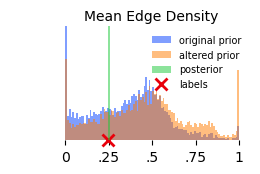

In [81]:
predictive_check_combined_hist(edge_densities_original, edge_densities_altered, edge_density_observed_data, edge_densities_posterior)
plt.savefig(FIGURES_PATH + 'predictive_check_histogram', dpi=300, bbox_inches='tight', pad_inches=0.01)
# MANUALLY CROPPED EXTRA WHITE SPACE IN PREVIEW (TOOLS > Select manually >> CROP)

In [16]:
sample_idx = 3
logits = \
    dpg_bnn.forward_pass_vmap()( #compute_edge_logits_vmap(
        samples['theta'], 
        samples['delta'],
        samples['b'], 
        posterior_model_args['x'], 
        posterior_model_args['w_init'],
        posterior_model_args['lam_init'],
        posterior_model_args['depth'],
        posterior_model_args['S'])
probs = jax.nn.sigmoid(logits)
probs = jax.nn.sigmoid(logits)
mean_prob, stdv_prob = np.array(probs.mean(axis=0)), np.array(probs.std(axis=0))
mean_prob_adj, stdv_prob_adj, y_adj = vec2adj(mean_prob, n), vec2adj(stdv_prob, n), vec2adj(y_val, n)

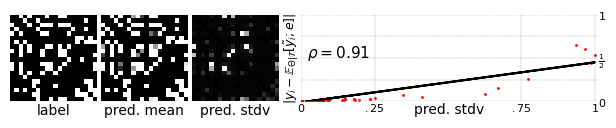

In [61]:

fig = plt.figure(figsize=(10, 1.125))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 2], figure=fig) #, wspace=0.001, hspace=0.001)

# Label, Mean, Std Deviation plots
label_ax = fig.add_subplot(gs[0, 0])
mean_ax = fig.add_subplot(gs[0, 1])
stdv_ax = fig.add_subplot(gs[0, 2])
error_ax = fig.add_subplot(gs[0, 3])

# Display images for label, mean, and std deviation
label_ax.imshow(y_adj[sample_idx], cmap="gray", vmin=0, vmax=1)
mean_ax.imshow(mean_prob_adj[sample_idx], cmap="gray", vmin=0, vmax=1)
stdv_norm = stdv_prob / np.max(stdv_prob, axis=1, keepdims=True)
stdv_norm_adj = vec2adj(stdv_norm[sample_idx], n)
expected_error = np.abs((mean_prob - np.array(y_val)))
stdv_ax.imshow(stdv_norm_adj[sample_idx], cmap="gray", vmin=0, vmax=1)

# Scatter plot for error vs std deviation
error_ax.scatter(stdv_norm[sample_idx].flatten(), expected_error[sample_idx].flatten(), color="r", s=1)

# Linear regression fit
reg = LinearRegression().fit(stdv_norm[sample_idx].flatten().reshape(-1, 1), expected_error[sample_idx].flatten().reshape(-1, 1))
error_ax.plot(stdv_norm[sample_idx].flatten(), reg.predict(stdv_norm[sample_idx].flatten().reshape(-1, 1)), color="k")
ccs = [jnp.corrcoef(stdv_prob[i].flatten(), expected_error[i].flatten())[0, 1].item() for i in range(len(y_val))]
error_ax.text(0.02, 0.5, r"$\rho = $" + f"{ccs[sample_idx]:.2f}", transform=error_ax.transAxes, fontsize=11)

# Customizing the subplots
rhs_axes = [label_ax, mean_ax, stdv_ax, error_ax]
titles = ['label', 'pred. mean', 'pred. stdv']

for ax, title in zip(rhs_axes[:-1], titles):
    #ax.set_title(title, fontsize=10, pad=0)
    ax.set_xlabel(title, fontsize=10, labelpad=2)

for ax in rhs_axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)

# Customizing the scatter plot
error_ax.tick_params(axis='x', which='major', pad=0, length=0, width=0.5)
error_ax.set_xticks([0, .25, .75, 1])
error_ax.set_xticklabels([r'$0$', r'$.25$', r'$.75$', r'$1$'], fontsize=8)
error_ax.set_yticks([0, .25, .5, .75, 1])
error_ax.set_yticklabels([r'$0$', r'', r'$\frac{1}{2}$', r'', r'$1$'], fontsize=8)
error_ax.tick_params(axis='y', which='major', pad=0, length=0, width=0.5)
error_ax.yaxis.set_ticks_position('right')
error_ax.set_xlabel(r'pred. stdv', fontsize=10, labelpad=-8)
error_ax.set_ylabel(r'$|y_i - \mathbb{E}_{\Theta|\mathcal{T}}[\tilde{y}_i;e]|$', fontsize=9, labelpad=0)
error_ax.grid(True, which="both", linestyle='--', linewidth=0.25, color='k', alpha=0.5)
error_ax.set_xlim(0, 1.01)
error_ax.set_ylim(0, 1)

# Adjusting subplot spaces manually
label_pos = label_ax.get_position()
mean_pos = mean_ax.get_position()
stdv_pos = stdv_ax.get_position()
error_pos = error_ax.get_position()

# Adjusting positions to make them closer
label_ax.set_position([label_pos.x0, label_pos.y0, label_pos.width * 1.1, label_pos.height])
mean_ax.set_position([label_pos.x0 + label_pos.width * 1.05, mean_pos.y0, mean_pos.width * 1.1, mean_pos.height])
stdv_ax.set_position([label_pos.x0 + 2 * label_pos.width * 1.05, stdv_pos.y0, stdv_pos.width * 1.1, stdv_pos.height])
error_ax.set_position([label_pos.x0 + 3.25 * label_pos.width * 1.05, error_pos.y0, error_pos.width * 1.1, error_pos.height])
plt.savefig(FIGURES_PATH + 'synthetic_label_predMean_predStdv', dpi=300, bbox_inches='tight', pad_inches=0.01)
plt.show()


In [ ]:
"""
    Combine Edge Density of Prior Predictive and Posterior Predictive with Label, Mean, and Stdv of posterior predictive
"""
fig = plt.figure(figsize=(6.50127, 2.25))
num_grid_rows, num_grid_cols = 100, 100
gs = GridSpec(num_grid_rows, num_grid_cols, figure=fig,  wspace=20, hspace=0.1)
end_hist_col = 40


""" Edge Density Histogram """
# edge densities: first two columns
density_ax = fig.add_subplot(gs[:, :end_hist_col])

alpha = 0.5
colors = sns.color_palette('bright', 4)
density_ax.hist(np.array(edge_densities_original).flatten(),
                bins=100,
                color=colors[0],
                alpha=alpha, density=True, label='original prior')
density_ax.hist(np.array(edge_densities_altered).flatten(),
                bins=100,
                color=colors[1],
                alpha=alpha, density=True, label='altered prior')
# make custom bins for posterior predictive: .2 to .3
posterior_bins = np.linspace(.2, .3, 10)
density_ax.hist(np.array(edge_densities_posterior).flatten(),
                bins=posterior_bins,
                color=colors[2],
                alpha=alpha, density=True, label='posterior')
# place 'x' where the mean of the labels are
density_ax.plot(np.mean(edge_density(y_val)), 0, 'x', color=colors[3], label=r'labels', zorder=10) #r'labels $\mathcal{T}_y$'
# remove yticks and labels
for ax in [density_ax]: #, density_ax2]:
    ax.set_yticks([])
    ax.set_ylabel('')
    # remove frame on all sides
    for side in ['top', 'right', 'bottom', 'left']:
        ax.spines[side].set_visible(False)
density_ax.set_xticks([0, .25, .5, .75, 1])
density_ax.set_xticklabels([r'$0$', r'$.25$', r'$.5$', r'$.75$', r'$1$'], fontsize=8)
density_ax.set_title('average edge density', fontsize=10, pad=2)

# make a common legend
density_ax.legend(loc='upper right', frameon=False, fontsize=6)
density_ax.set_ylim([0, 3.8])

""" Label | Posterior Pred. Mean | Posterior Pred. Stdv | Error vs Stdv """

# label / posterior mean / stdv / error vs stdv scatter plot
sample_idx = 3
logits = \
    dpg_bnn.forward_pass_vmap()( #compute_edge_logits_vmap(
        samples['theta'], 
        samples['delta'],
        samples['b'], 
        posterior_model_args['x'], 
        posterior_model_args['w_init'],
        posterior_model_args['lam_init'],
        posterior_model_args['depth'],
        posterior_model_args['S'])
probs = jax.nn.sigmoid(logits)
probs = jax.nn.sigmoid(logits)
mean_prob, stdv_prob = np.array(probs.mean(axis=0)), np.array(probs.std(axis=0))
mean_prob_adj, stdv_prob_adj, y_adj = vec2adj(mean_prob, n), vec2adj(stdv_prob, n), vec2adj(y_val, n)

# add subplots for label, mean, stdv, error vs stdv in the last 4 columns
# label: rows from 0 to 60, cols from 40 to 100
end_row = 61
end_hist_col += 3
width = (100 - end_hist_col)//3
label_ax = fig.add_subplot(gs[:end_row, end_hist_col:end_hist_col+width])
mean_ax = fig.add_subplot(gs[:end_row, end_hist_col+width:end_hist_col+2*width])
stdv_ax = fig.add_subplot(gs[:end_row, end_hist_col+2*width:end_hist_col+3*width])

error_ax = fig.add_subplot(gs[end_row:, end_hist_col:])
rhs_axes = [label_ax, mean_ax, stdv_ax, error_ax]
label_ax.imshow(y_adj[sample_idx], cmap="gray", vmin=0, vmax=1)
mean_ax.imshow(mean_prob_adj[sample_idx], cmap="gray", vmin=0, vmax=1)
stdv_norm = stdv_prob/np.max(stdv_prob, axis=1, keepdims=True)
stdv_norm_adj = vec2adj(stdv_norm[sample_idx], n)
expected_error = np.abs((mean_prob - np.array(y_val)))
stdv_ax.imshow(stdv_norm_adj[sample_idx], cmap="gray", vmin=0, vmax=1)
#axes[3].scatter(expected_error[sample_idx].flatten(), (stdv_prob/stdv_prob.max(axis=0))[sample_idx].flatten(), color="k", s=1)
error_ax.scatter(stdv_norm[sample_idx].flatten(),
                 expected_error[sample_idx].flatten(), color="r", s=1)
# find the correlation coefficient between stdv and expected_error
ccs = [jnp.corrcoef(stdv_prob[i].flatten(), expected_error[i].flatten())[0,1].item() for i in range(len(y_val))]
print('correlation coefficients. mean: ', {np.mean(ccs)}, 'std: ', {np.std(ccs)}, ccs)


# fit a line to expected error abs vs stdv norm
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(stdv_norm[sample_idx].flatten().reshape(-1, 1),
                             expected_error[sample_idx].flatten().reshape(-1, 1))
error_ax.plot(stdv_norm[sample_idx].flatten(), reg.predict(stdv_norm[sample_idx].flatten().reshape(-1, 1)), color="k")
# place text indicating details of the fit line
#error_ax.text(0.02, 0.51, r"$\rho = $" + f"{reg.score(stdv_norm[sample_idx].flatten().reshape(-1, 1), expected_error[sample_idx].flatten().reshape(-1, 1)):.2f}", transform=error_ax.transAxes, fontsize=11)
error_ax.text(0.02, 0.51, r"$\rho = $" + f"{ccs[sample_idx]:.2f}", transform=error_ax.transAxes, fontsize=11)

for ax in rhs_axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    # remove the frame
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)

# make titles closer to the plots
titles = ['label', 'pred. mean', 'pred. stdv']#, 'error vs stdv']
for ax, title in zip(rhs_axes[:-1], titles):
    ax.set_title(title, fontsize=10, pad=0)

# customize scatter plot
error_ax.tick_params(axis='x', which='major', pad=0, length=0, width=0.5)
error_ax.set_xticks([0, .25, .75, 1])
error_ax.set_xticklabels([r'$0$', r'$.25$', r'$.75$', r'$1$'], fontsize=8)
error_ax.set_yticks([0, .25, .5, .75, 1])
error_ax.set_yticklabels([r'$0$', r'', r'$\frac{1}{2}$', r'', r'$1$'], fontsize=8)
error_ax.tick_params(axis='y', which='major', pad=0, length=0, width=0.5)
# move yticks and labels to the right
error_ax.yaxis.set_ticks_position('right')
error_ax.set_xlabel(r'pred. stdv', fontsize=10, labelpad=-8)
#error_ax.set_ylabel(r'$|y_i - \mathbb{E}_{\Theta|\mathcal{T}}[\tilde{y}_i]|$', fontsize=10, labelpad=2) #, labelpad=10, rotation=270,)
error_ax.set_ylabel(r'$|y_i - \mathbb{E}_{\Theta|\mathcal{T}}[\tilde{y}_i;e]|$', fontsize=9, labelpad=2) #, labelpad=10, rotation=270,)
error_ax.grid(True, which="both", linestyle='--', linewidth=0.25, color='k', alpha=0.5)

# manually set the space between the subplots
delta = 0.01
error_ax.set_xlim(0, 1+delta)
error_ax.set_ylim(0-delta, 1+delta)
space = 0.01
plt.subplots_adjust(wspace=space, hspace=0, bottom=0.0, top=1, left=0.0, right=1.0)
plt.savefig(FIGURES_PATH + 'predictive_check', dpi=1000, bbox_inches='tight', pad_inches=0.01)

In [ ]:
# How useful is the stdv in predicting errors?
errors_idxs = np.where(y_val[sample_idx] != (mean_prob[sample_idx] >= 0.5))[0]
for k in range(1, 21):
    # compute percentage of the k largest stdv values that are errors
    k_largest_stdv_idxs = np.argsort(stdv_prob[sample_idx].flatten())[-k:]
    #k_largest_stdv_idxs_2d = [[idx % n, idx // n] for idx in k_largest_stdv_idxs]
    # how many of the k largest stdv values are errors?
    num_errors = 0
    for idx in k_largest_stdv_idxs:
        if idx in errors_idxs:
            num_errors += 1
    print(f"Percentage of the {k} largest stdv values that are errors: {(num_errors / len(k_largest_stdv_idxs))*100:.2f}%")
